In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/cmu_lectures/cmu_optimal_control_course/lecturenotes/lecture_notes/Lecture 7/Project.toml`


In [2]:
using LinearAlgebra
using PyPlot
using ControlSystems

In [4]:
# Discrete dynamics
h = 0.1   # time step
A = [1 h; 0 1]
B = [0.5*h*h; h]

2-element Vector{Float64}:
 0.005000000000000001
 0.1

In [5]:
n = 2     # number of state
m = 1     # number of controls
Tfinal = 10.0 # final time
N = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(N-1), step=h));

In [6]:
# Initial conditions
x0 = [1.0; 0]

2-element Vector{Float64}:
 1.0
 0.0

In [7]:
# Cost weights
Q = Array(1.0*I(2))
R = 0.1  # Array(1.0*I(1))
Qn = Array(1.0*I(2))

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [8]:
#Cost function
function J(xhist,uhist)
    cost = 0.5*xhist[:,end]'*Qn*xhist[:,end]
    for k = 1:(N-1)
        cost = cost + 0.5*xhist[:,k]'*Q*xhist[:,k] + 0.5*(uhist[k]'*R*uhist[k])[1]
    end
    return cost
end

J (generic function with 1 method)

In [13]:
P = zeros(n,n,N)
K = zeros(m,n,N-1)

P[:,:,N] .= Qn

#Backward Riccati recursion
for k = (N-1):-1:1
    K[:,:,k] .= (R + B'*P[:,:,k+1]*B)\(B'*P[:,:,k+1]*A)
    P[:,:,k] .= Q + A'*P[:,:,k+1]*(A-B*K[:,:,k])
end

display(K)

#Forward rollout starting at x0
xhist = zeros(n,N)
xhist[:,1] = x0
uhist = zeros(m,N-1)
for k = 1:(N-1)
    uhist[:,k] .= -K[:,:,k]*xhist[:,k]
    xhist[:,k+1] .= A*xhist[:,k] + B*uhist[k]
end

1×2×100 Array{Float64, 3}:
[:, :, 1] =
 2.5857  3.44344

[:, :, 2] =
 2.5857  3.44344

[:, :, 3] =
 2.5857  3.44344

...

[:, :, 98] =
 0.326177  2.12671

[:, :, 99] =
 0.163769  1.62789

[:, :, 100] =
 0.0454442  0.913429

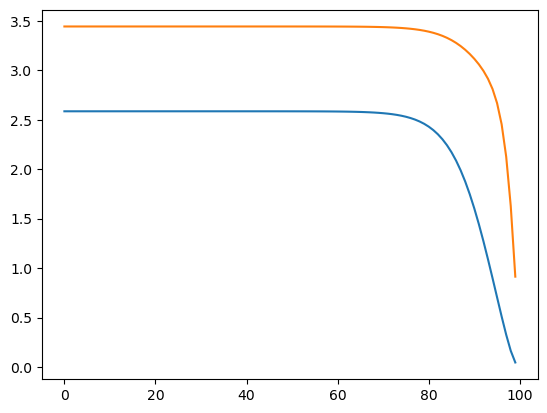

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3666e364f0>

In [16]:
plot(K[1,1,:])
plot(K[1,2,:])

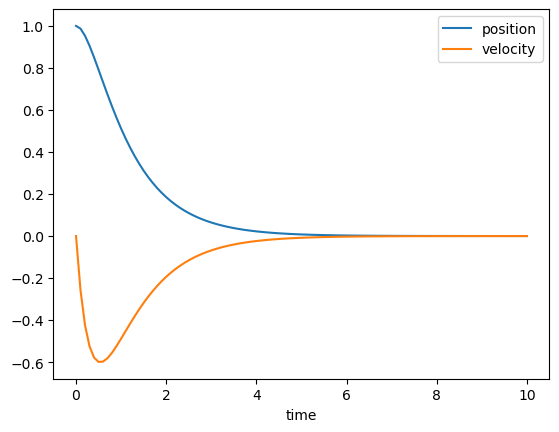

PyObject <matplotlib.legend.Legend object at 0x7f3666e00ac0>

In [17]:
# Plot x1 vs. x2, u vs. t, x vs. t, etc.
times = range(0,h*(N-1), step=h)
plot(times,xhist[1,:], label="position")
plot(times,xhist[2,:], label="velocity")
xlabel("time")
legend()

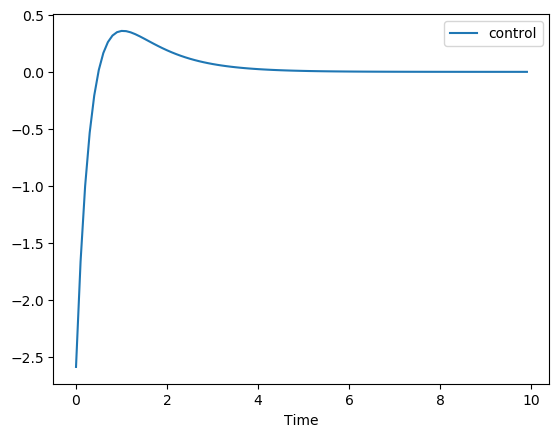

PyObject <matplotlib.legend.Legend object at 0x7f3664b29c40>

In [18]:
plot(times[1:end-1], uhist[1,:], label="control")
xlabel("Time")
legend()

In [19]:
J(xhist,uhist)

6.658612208961312

In [20]:
#Forward rollout with random noise
xhist = zeros(n,N)
xhist[:,1] = x0 #10.0*randn(2) #Can start anywhere
uhist = zeros(m,N-1)
for k = 1:(N-1)
    uhist[:,k] .= -K[:,:,k]*xhist[:,k]
    xhist[:,k+1] .= A*xhist[:,k] + B*uhist[k] + 0.01*randn(2) #can add noise to dynamics
end

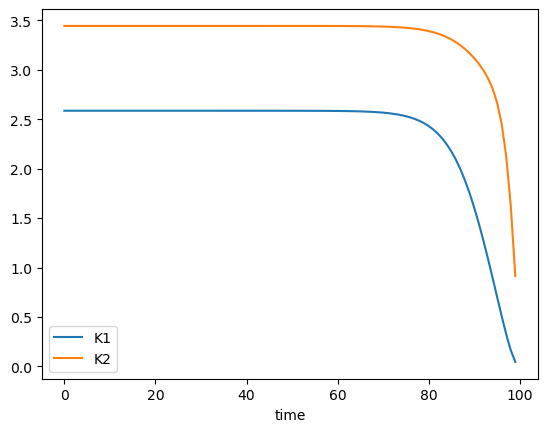

PyObject <matplotlib.legend.Legend object at 0x7f3666e8cd00>

In [21]:
plot(K[1,1,:], label="K1")
plot(K[1,2,:], label="K2")
xlabel("time")
legend()

In [24]:
#Compute infinite-horizon K matrix using ControlSystems.jl
Kinf = dlqr(A,B,Q,R)
#Compare to ours
K[:,:,1]-Kinf
display(K[:,:,1])
display(Kinf)

1×2 Matrix{Float64}:
 2.5857  3.44344

1×2 Matrix{Float64}:
 2.5857  3.44344

In [40]:
#Forward rollout with constant K
N = Int(5/h)+1    # number of time steps
xhist = zeros(n,N)
xhist[:,1] = x0 #Can start anywhere
uhist = zeros(m,N-1)
for k = 1:(N-1)
    uhist[:,k] .= -Kinf*xhist[:,k]
    xhist[:,k+1] .= A*xhist[:,k] + B*uhist[k] + 0.01*randn(2)
end

In [41]:
#Closed-loop Eigenvalues
eigvals(A-B*Kinf)

2-element Vector{Float64}:
 0.7435575978433926
 0.8991703058887752

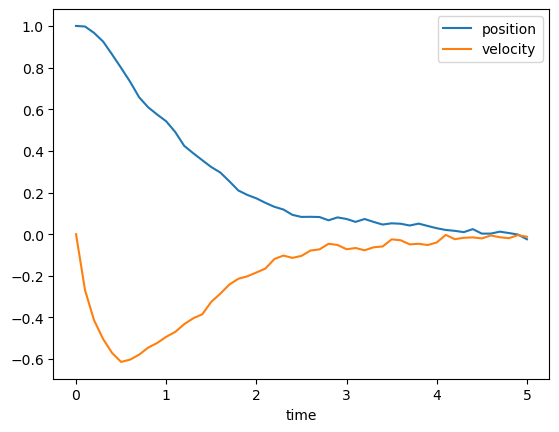

PyObject <matplotlib.legend.Legend object at 0x7f36648be7f0>

In [42]:
# Plot x1 vs. x2, u vs. t, x vs. t, etc.
times = range(0,h*(N-1), step=h)
plot(times,xhist[1,:], label="position")
plot(times,xhist[2,:], label="velocity")
xlabel("time")
legend()